Ce fichier porte sur les statistiques descriptives permettant de présenter les différentes bases de données que nous avons à disposition.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Description des données de ratings

In [39]:
# Charger le fichier Excel
data = pd.read_excel("data\credit_ratings\data_rating_corporate.xlsx")

# Afficher les premières lignes
data.head()

<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\HP\AppData\Local\Temp\ipykernel_11164\3828515331.py:2: SyntaxWarning: invalid escape sequence '\c'
  data = pd.read_excel("data\credit_ratings\data_rating_corporate.xlsx")


,rating_agency_name,rating,rating_action_date,legal_entity_identifier,obligor_name,year_month,year,pays,nace
0,Egan-Jones Ratings Company,B,2022-07-22,NaN,"06 ENVIRONMENTAL, LLC",2022-07-01,2023,NaN,RU
1,Egan-Jones Ratings Company,B,2023-07-21,NaN,"06 ENVIRONMENTAL, LLC",2023-07-01,2024,NaN,RU
2,Egan-Jones Ratings Company,B,2023-09-18,NaN,"06 ENVIRONMENTAL, LLC",2023-09-01,2024,NaN,RU
3,Fitch Ratings,B,2021-08-18,549300ETSKJL315VDV79,"11065220 Canada, Inc.",2021-08-01,2022,NaN,RU
4,Fitch Ratings,C,2022-06-27,549300ETSKJL315VDV79,"11065220 Canada, Inc.",2022-06-01,2022,NaN,RU


Nettoyage des données

In [40]:
def clean_data_rating_corporate(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 1) Dates
    df["rating_action_date"] = pd.to_datetime(df["rating_action_date"], errors="coerce")

    # year_month : souvent "YYYY-MM-01" en string -> datetime Month Start
    df["year_month"] = pd.to_datetime(df["year_month"], errors="coerce")

    # Si year_month est manquant mais rating_action_date est dispo, on le reconstruit
    missing_ym = df["year_month"].isna() & df["rating_action_date"].notna()
    df.loc[missing_ym, "year_month"] = df.loc[missing_ym, "rating_action_date"].dt.to_period("M").dt.to_timestamp()

    # 2) Strings : trim
    for c in ["rating_agency_name", "rating", "legal_entity_identifier", "obligor_name", "pays", "nace"]:
        df[c] = df[c].astype("string").str.strip()

    # 3) ID entreprise : LEI si dispo sinon nom
    lei_ok = df["legal_entity_identifier"].notna() & (df["legal_entity_identifier"] != "")
    name_ok = df["obligor_name"].notna() & (df["obligor_name"] != "")
    df["obligor_id"] = np.where(lei_ok, df["legal_entity_identifier"], np.where(name_ok, df["obligor_name"], pd.NA))

    # 4) Nettoyage secteur (NACE)
    # (Tu peux adapter selon ton codage : lettres, divisions, etc.)
    df["nace"] = df["nace"].str.upper()

    # 5) Nettoyage rating
    df["rating"] = df["rating"].str.upper()

    # 6) Filtrer les lignes inutilisables
    df = df[df["obligor_id"].notna()].copy()
    df = df[df["year_month"].notna()].copy()
    df = df[df["nace"].notna() & (df["nace"] != "")].copy()
    df = df[df["rating"].notna() & (df["rating"] != "")].copy()

    return df


def quick_diagnostics(df: pd.DataFrame):
    print("---- DIAGNOSTICS ----")
    print("Nb lignes:", len(df))
    print("Nb entreprises (obligor_id):", df["obligor_id"].nunique())
    print("Nb agences:", df["rating_agency_name"].nunique())
    print("Nb secteurs (nace):", df["nace"].nunique())
    print("Période year_month:", df["year_month"].min(), "->", df["year_month"].max())

    print("\nTop agences:")
    print(df["rating_agency_name"].value_counts().head(10))

    print("\nTop ratings:")
    print(df["rating"].value_counts().head(15))

    print("\nTop secteurs (nace):")
    print(df["nace"].value_counts().head(15))

In [41]:
data_clean = clean_data_rating_corporate(data)
quick_diagnostics(data_clean)

---- DIAGNOSTICS ----
Nb lignes: 109161
Nb entreprises (obligor_id): 13944
Nb agences: 5
Nb secteurs (nace): 18
Période year_month: 2010-07-01 00:00:00 -> 2024-04-01 00:00:00

Top agences:
rating_agency_name
Egan-Jones Ratings Company            55414
Standard & Poor's Ratings Services    38151
Moody's Investors Service              6306
Japan Credit Rating Agency,Ltd.        5856
Fitch Ratings                          3434
Name: count, dtype: Int64

Top ratings:
rating
BBB    29025
B      24599
A      22268
BB     20638
C       6638
AAA     5482
D        511
Name: count, dtype: Int64

Top secteurs (nace):
nace
KZ    13782
C5    13418
C3    11983
RU    10508
JZ    10142
BZ     8418
LZ     7427
HZ     6164
GZ     5047
C1     5032
OQ     4664
CH     2398
C4     2337
C2     2322
IZ     1901
Name: count, dtype: Int64


Evolution temporelle du volume de ratings par note de ratings

In [43]:
# Copie de travail
df = data_clean.copy()

# Harmonisation (sécurité)
df["rating"] = df["rating"].str.upper().str.strip()

# Fonction de regroupement des ratings
def rating_bucket(r):
    if r in ["AAA"]:
        return "AAA"
    elif r in ["AA+", "AA", "AA-"]:
        return "AA"
    elif r in ["A+", "A", "A-"]:
        return "A"
    elif r in ["BBB+", "BBB", "BBB-"]:
        return "BBB"
    elif r in ["BB+", "BB", "BB-"]:
        return "BB"
    elif r in ["B+", "B", "B-"]:
        return "B"
    elif r in ["CCC", "CC", "C"]:
        return "CCC–C"
    elif r in ["D", "SD", "DEFAULT"]:
        return "Default"
    else:
        return "Other"

df["rating_group"] = df["rating"].apply(rating_bucket)

In [44]:
# Agrégation annuelle
volume_time = (
    df
    .groupby(["year", "rating_group"])
    .size()
    .reset_index(name="n_obs")
)

# Pivot pour le graphique
volume_pivot = volume_time.pivot(
    index="year",
    columns="rating_group",
    values="n_obs"
).fillna(0)

# Tri logique des ratings
rating_order = ["AAA", "AA", "A", "BBB", "BB", "B", "CCC–C", "Default", "Other"]
volume_pivot = volume_pivot[[c for c in rating_order if c in volume_pivot.columns]]


<Figure size 1300x600 with 0 Axes>

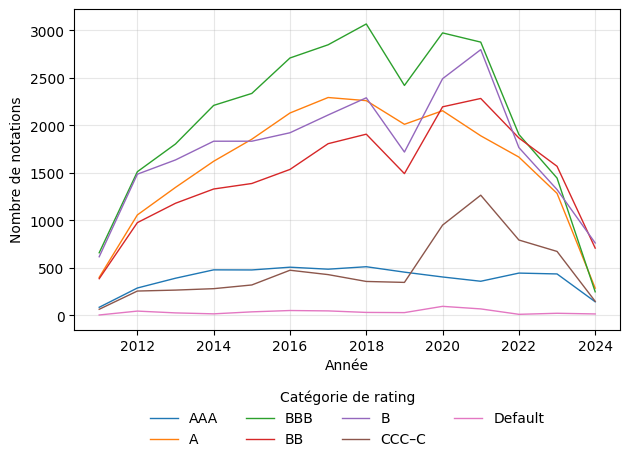

In [45]:
plt.figure(figsize=(13, 6))

volume_pivot.plot(
    kind="line",
    linewidth=1
)

plt.xlabel("Année")
plt.ylabel("Nombre de notations")

plt.legend(
    title="Catégorie de rating",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    frameon=False
)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Répartition du volume de notations par agence

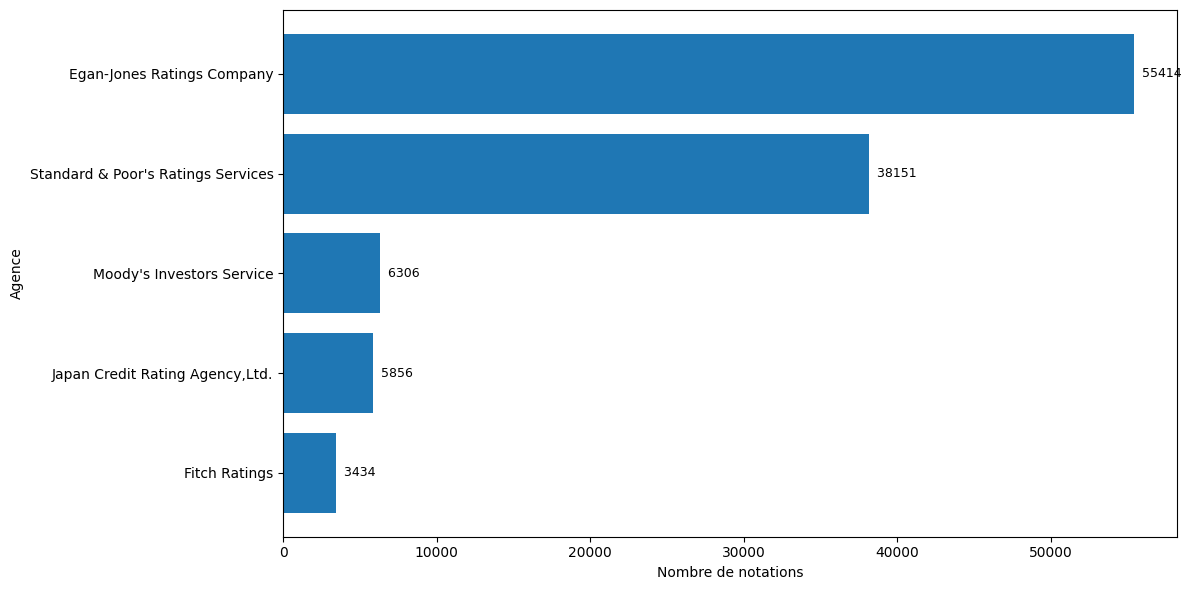

In [46]:
# Nettoyage léger
df["rating_agency_name"] = df["rating_agency_name"].astype(str).str.strip()

# Comptage
agency_counts = df["rating_agency_name"].value_counts(dropna=False)

# Top N + "Autres"
top_n = 10
top = agency_counts.head(top_n)
others = agency_counts.iloc[top_n:].sum()

plot_counts = top.copy()
if others > 0:
    plot_counts.loc("Autres") if False else None
    plot_counts["Autres"] = others

# Pour affichage en barres horizontales (du plus petit au plus grand)
plot_counts = plot_counts.sort_values()

plt.figure(figsize=(12, 6))
plt.barh(plot_counts.index, plot_counts.values)

plt.xlabel("Nombre de notations")
plt.ylabel("Agence")

# Ajout des valeurs au bout des barres (optionnel mais pratique)
for i, v in enumerate(plot_counts.values):
    plt.text(v, i, f"  {int(v)}", va="center", fontsize=9)

plt.tight_layout()
plt.show()

Variante en parts de marchés

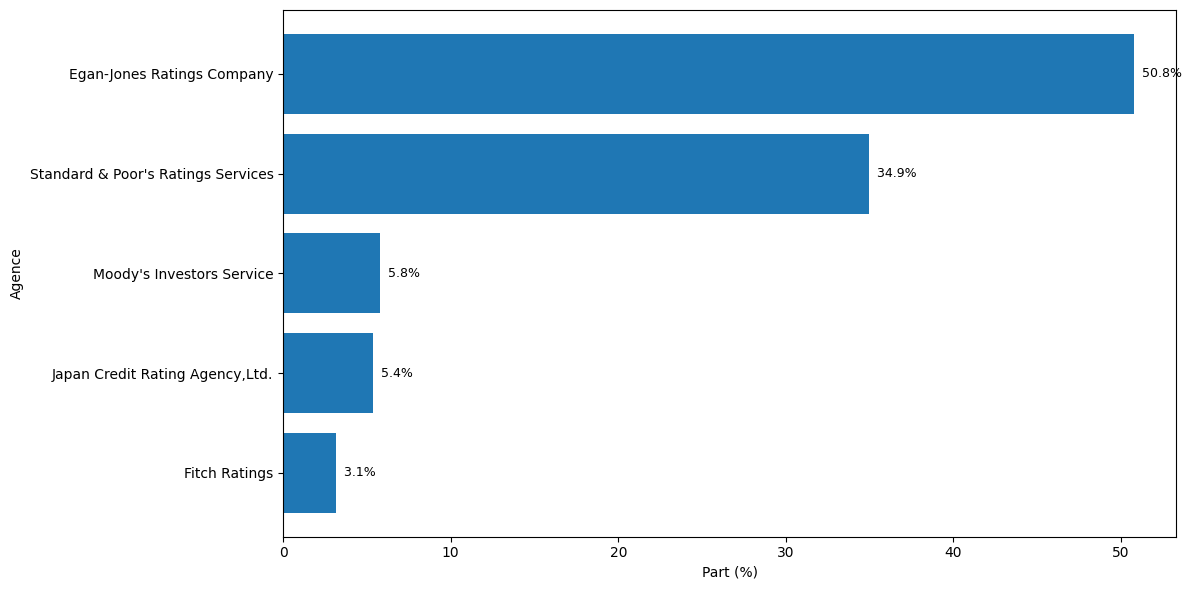

In [47]:
agency_share = (df["rating_agency_name"].value_counts(normalize=True) * 100)

top_n = 10
top = agency_share.head(top_n)
others = agency_share.iloc[top_n:].sum()

plot_share = top.copy()
if others > 0:
    plot_share["Autres"] = others

plot_share = plot_share.sort_values()

plt.figure(figsize=(12, 6))
plt.barh(plot_share.index, plot_share.values)

plt.xlabel("Part (%)")
plt.ylabel("Agence")

for i, v in enumerate(plot_share.values):
    plt.text(v, i, f"  {v:.1f}%", va="center", fontsize=9)

plt.tight_layout()
plt.show()


Evolution du volume de notation par agence dans le temps

<Figure size 1300x600 with 0 Axes>

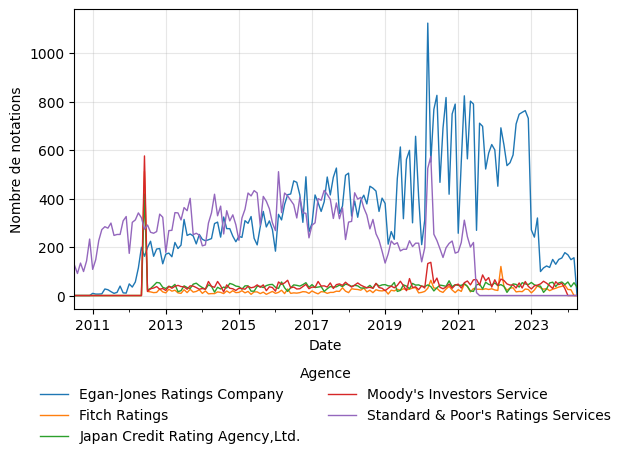

In [48]:
df["year_month"] = pd.to_datetime(df["year_month"])

top_agencies = df["rating_agency_name"].value_counts().head(5).index
tmp = (df[df["rating_agency_name"].isin(top_agencies)]
       .groupby(["year_month", "rating_agency_name"])
       .size()
       .unstack(fill_value=0))

plt.figure(figsize=(13, 6))
tmp.plot(kind="line", linewidth=1)

plt.xlabel("Date")
plt.ylabel("Nombre de notations")
plt.legend(title="Agence", loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Distribution globale des ratings

In [49]:
df["rating_group"] = df["rating_group"].astype(str)

rating_counts = df["rating_group"].value_counts()

# Ordre logique (meilleur → pire)
rating_order = ["AAA", "AA", "A", "BBB", "BB", "B", "CCC–C", "Default", "Other"]
rating_counts = rating_counts.reindex(
    [r for r in rating_order if r in rating_counts.index]
)

In [50]:
rating_share = rating_counts / rating_counts.sum() * 100


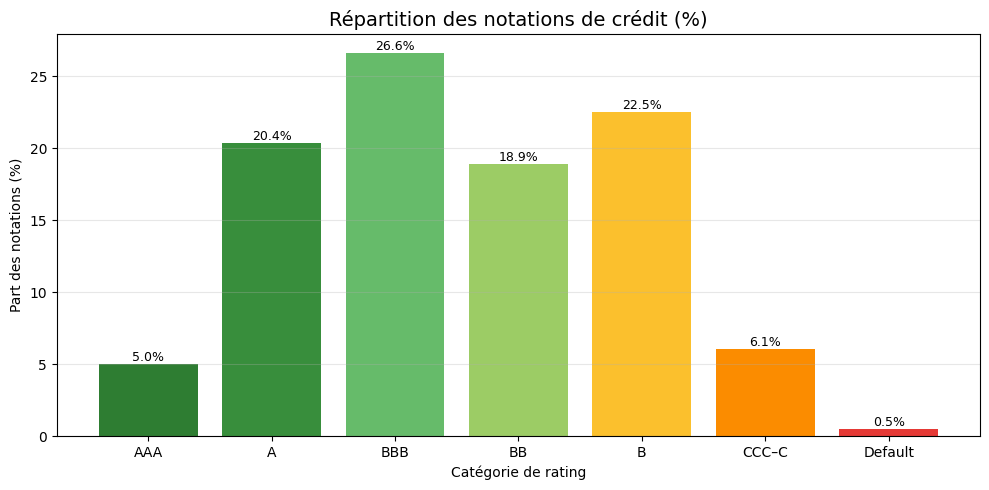

In [51]:
# Palette manuelle (investment grade -> speculative -> défaut)
colors = [
    "#2E7D32",  # AAA - vert foncé
    "#388E3C",  # AA
    "#66BB6A",  # A
    "#9CCC65",  # BBB
    "#FBC02D",  # BB - jaune
    "#FB8C00",  # B - orange
    "#E53935",  # CCC–C - rouge
    "#8E0000",  # Default - rouge foncé
    "#9E9E9E"   # Other - gris
]

# Ajuster si certaines catégories n'existent pas
colors = colors[:len(rating_share)]

plt.figure(figsize=(10, 5))

plt.bar(
    rating_share.index,
    rating_share.values,
    color=colors
)

plt.title("Répartition des notations de crédit (%)", fontsize=14)
plt.xlabel("Catégorie de rating")
plt.ylabel("Part des notations (%)")

for i, v in enumerate(rating_share.values):
    plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

Distribution des ratings par secteurs

In [52]:
sector_rating = (
    df
    .groupby(["nace", "rating_group"])
    .size()
    .unstack(fill_value=0)
)

# Passage en pourcentage par secteur
sector_rating_pct = sector_rating.div(
    sector_rating.sum(axis=1), axis=0
) * 100

# Ordre logique des ratings
rating_order = ["AAA", "AA", "A", "BBB", "BB", "B", "CCC–C", "Default", "Other"]
sector_rating_pct = sector_rating_pct[
    [r for r in rating_order if r in sector_rating_pct.columns]
]

# Tri des secteurs (optionnel mais plus lisible)
sector_rating_pct = sector_rating_pct.sort_index()

In [ ]:
rating_colors = {
    "AAA": "#2E7D32",
    "AA": "#388E3C",
    "A": "#66BB6A",
    "BBB": "#9CCC65",
    "BB": "#FBC02D",
    "B": "#FB8C00",
    "CCC–C": "#E53935",
    "Default": "#8E0000",
    "Other": "#9E9E9E"
}

colors = [rating_colors[r] for r in sector_rating_pct.columns]

<Figure size 1400x600 with 0 Axes>

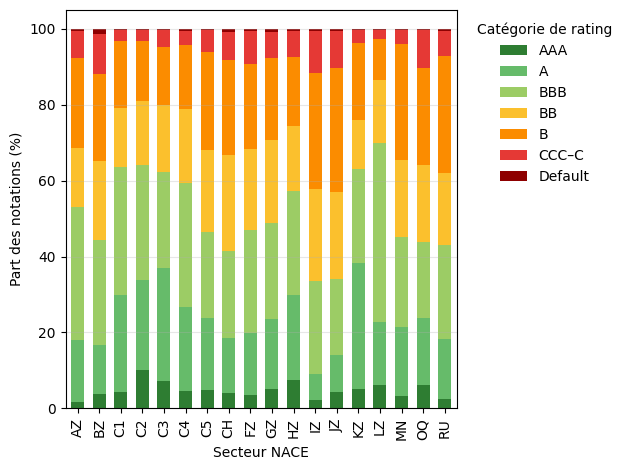

In [56]:
plt.figure(figsize=(14, 6))

sector_rating_pct.plot(
    kind="bar",
    stacked=True,
    color=colors,
    width=0.6
)

plt.xlabel("Secteur NACE")
plt.ylabel("Part des notations (%)")

plt.legend(
    title="Catégorie de rating",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

Rpartition géographique

In [58]:
# Nombre total de pays distincts (hors NA)
n_countries = df["pays"].nunique(dropna=True)

# Part des observations sans pays
share_na_country = df["pays"].isna().mean() * 100

print(f"Nombre de pays distincts (hors NA) : {n_countries}")
print(f"Part des notations sans pays : {share_na_country:.2f}%")

Nombre de pays distincts (hors NA) : 74
Part des notations sans pays : 39.16%


In [ ]:
firms_per_country = (
    df
    .dropna(subset=["pays"])
    .groupby("pays")["obligor_id"]
    .nunique()
    .sort_values(ascending=False)
)

print(firms_per_country.head(10))


pays
US    4329
JP     447
GB     355
CA     274
NL     181
BR     159
LU     139
FR     131
RU     120
DE     105
Name: obligor_id, dtype: int64


In [61]:
ratings_per_country = (
    df
    .dropna(subset=["pays"])
    .groupby("pays")
    .size()
    .sort_values(ascending=False)
)

print(ratings_per_country.head(10))


pays
US    41480
JP     5537
CA     4682
GB     2427
NL     1275
DE     1122
FR      922
IE      734
BR      716
AU      621
dtype: int64


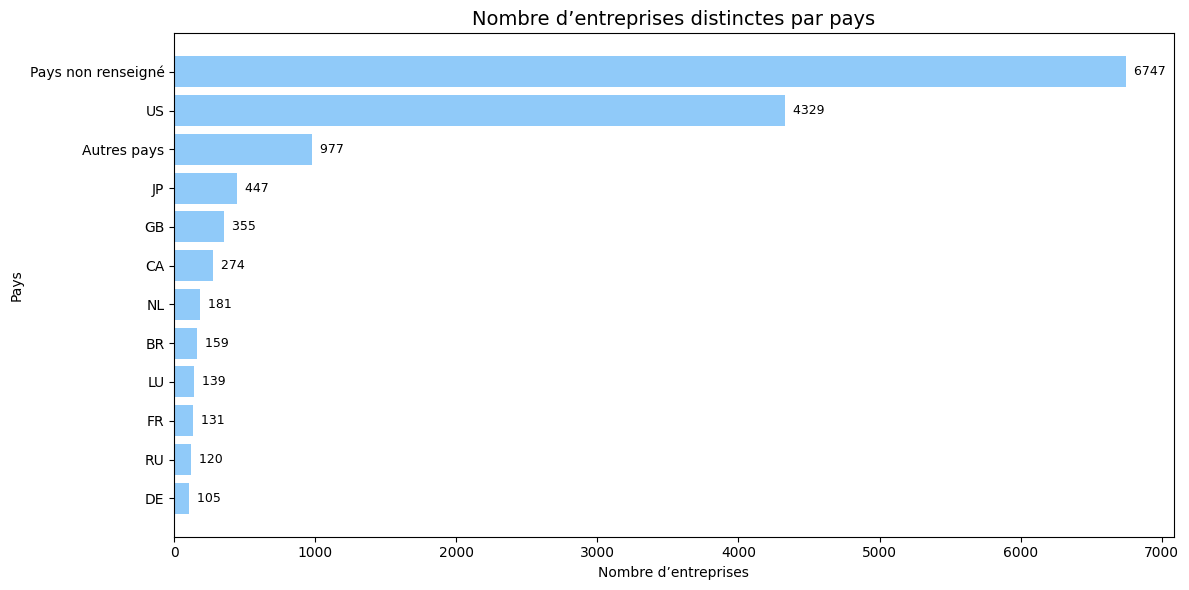

In [62]:
# Comptage des entreprises distinctes par pays
firms_per_country = (
    df
    .groupby("pays")["obligor_id"]
    .nunique()
    .sort_values(ascending=False)
)

# Top pays
top_n = 10
top_countries = firms_per_country.head(top_n)

# Autres pays
others = firms_per_country.iloc[top_n:].sum()

# Pays manquant
na_firms = df[df["pays"].isna()]["obligor_id"].nunique()

plot_data = top_countries.copy()
plot_data["Autres pays"] = others
plot_data["Pays non renseigné"] = na_firms

# Tri pour barres horizontales
plot_data = plot_data.sort_values()

plt.figure(figsize=(12, 6))
plt.barh(plot_data.index, plot_data.values, color="#90CAF9")

plt.title("Nombre d’entreprises distinctes par pays", fontsize=14)
plt.xlabel("Nombre d’entreprises")
plt.ylabel("Pays")

for i, v in enumerate(plot_data.values):
    plt.text(v, i, f"  {int(v)}", va="center", fontsize=9)

plt.tight_layout()
plt.show()
